### Stanford Paper on LSTM Neural Networks for stock prices volatility prediction

http://cs230.stanford.edu/projects_fall_2019/reports/26254244.pdf

### Tutorial for building an LSTM neural network for time-series prediction

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

### Importing the required libraries

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

# Scikit-Learn

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# GARCH model

import pyflux as pf

# Keras

from keras.models import Model
from keras.layers import *
from keras.utils.vis_utils import plot_model

# Tensorflow

import tensorflow as tf

### Reading the csv file with the financial data

In [255]:
df = pd.read_csv(r'input/financial_data.csv')

print (df.head())
print (df.shape)

     20190610    20190611    20190612    20190613    20190614    20190617  \
0      134.38      135.32      135.56      135.13      135.44      135.39   
1      134.74      135.95      134.87      135.76      135.15      134.95   
2      135.35      136.46      135.94      136.27      135.88      136.03   
3      133.91      135.05      134.41      135.09      134.43      134.70   
4  2911327.00  3407345.00  2254741.00  2955419.00  2193367.00  2194129.00   

     20190618    20190619    20190620    20190621     ...        20200528  \
0      135.20      136.43      138.93      138.44     ...          126.87   
1      136.38      137.08      138.85      139.20     ...          124.53   
2      137.19      138.36      139.54      139.54     ...          126.97   
3      135.20      136.24      138.20      138.39     ...          124.22   
4  2914698.00  2382520.00  3071017.00  5288759.00     ...      3916377.00   

     20200529    20200601    20200602    20200603    20200604    20200605 

As we see here, we have 254 columns, corresponding to the 254 business days for which we have financial data and 10 columns, which are the 10 financial indicators we have.

### Transposing the dataframe 

As we are working with time series data, we should have the dates as one column and will thus use transpose() for this.

In [256]:
df = df.transpose()

print(df.head())
print(df.shape)

               0       1       2       3          4    5    6    7    8    9
20190610  134.38  134.74  135.35  133.91  2911327.0  0.0  0.0  0.0  0.0  0.0
20190611  135.32  135.95  136.46  135.05  3407345.0  0.0  0.0  0.0  0.0  0.0
20190612  135.56  134.87  135.94  134.41  2254741.0  0.0  0.0  0.0  0.0  0.0
20190613  135.13  135.76  136.27  135.09  2955419.0  0.0  0.0  0.0  0.0  0.0
20190614  135.44  135.15  135.88  134.43  2193367.0  0.0  0.0  0.0  0.0  0.0
(254, 10)


### Reset the index of the dataframe

In [257]:
df = df.reset_index()

print(df.head())

      index       0       1       2       3          4    5    6    7    8  \
0  20190610  134.38  134.74  135.35  133.91  2911327.0  0.0  0.0  0.0  0.0   
1  20190611  135.32  135.95  136.46  135.05  3407345.0  0.0  0.0  0.0  0.0   
2  20190612  135.56  134.87  135.94  134.41  2254741.0  0.0  0.0  0.0  0.0   
3  20190613  135.13  135.76  136.27  135.09  2955419.0  0.0  0.0  0.0  0.0   
4  20190614  135.44  135.15  135.88  134.43  2193367.0  0.0  0.0  0.0  0.0   

     9  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  


### Renaming the columns with the financial indicators name

In [258]:
df = df.rename(columns={
    
    df.columns[0]: 'Date',
    df.columns[1]:'Open',
    df.columns[2]: 'Close',
    df.columns[3]:'High',
    df.columns[4]:'Low',
    df.columns[5]: 'Volume',
    df.columns[6]: 'RSI14',
    df.columns[7]:'SMA14',
    df.columns[8]: 'EMA14',
    df.columns[9]:'MACD_sl',
    df.columns[10]:'MACD_h'

})

print (df.head())

       Date    Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
0  20190610  134.38  134.74  135.35  133.91  2911327.0    0.0    0.0    0.0   
1  20190611  135.32  135.95  136.46  135.05  3407345.0    0.0    0.0    0.0   
2  20190612  135.56  134.87  135.94  134.41  2254741.0    0.0    0.0    0.0   
3  20190613  135.13  135.76  136.27  135.09  2955419.0    0.0    0.0    0.0   
4  20190614  135.44  135.15  135.88  134.43  2193367.0    0.0    0.0    0.0   

   MACD_sl  MACD_h  
0      0.0     0.0  
1      0.0     0.0  
2      0.0     0.0  
3      0.0     0.0  
4      0.0     0.0  


### Converting the Date column into a Date

In [259]:
df['Date'] =  pd.to_datetime(df['Date'])

### Setting the Date column as the index

In [260]:
df.set_index('Date', inplace=True)

print(df.head())

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
2019-06-10  134.38  134.74  135.35  133.91  2911327.0    0.0    0.0    0.0   
2019-06-11  135.32  135.95  136.46  135.05  3407345.0    0.0    0.0    0.0   
2019-06-12  135.56  134.87  135.94  134.41  2254741.0    0.0    0.0    0.0   
2019-06-13  135.13  135.76  136.27  135.09  2955419.0    0.0    0.0    0.0   
2019-06-14  135.44  135.15  135.88  134.43  2193367.0    0.0    0.0    0.0   

            MACD_sl  MACD_h  
Date                         
2019-06-10      0.0     0.0  
2019-06-11      0.0     0.0  
2019-06-12      0.0     0.0  
2019-06-13      0.0     0.0  
2019-06-14      0.0     0.0  


## Engineering additional features

### Log Returns

In [261]:
df['Log_Returns'] = np.log(df.Close) - np.log(df.Close.shift(1))

print(df.head())

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
2019-06-10  134.38  134.74  135.35  133.91  2911327.0    0.0    0.0    0.0   
2019-06-11  135.32  135.95  136.46  135.05  3407345.0    0.0    0.0    0.0   
2019-06-12  135.56  134.87  135.94  134.41  2254741.0    0.0    0.0    0.0   
2019-06-13  135.13  135.76  136.27  135.09  2955419.0    0.0    0.0    0.0   
2019-06-14  135.44  135.15  135.88  134.43  2193367.0    0.0    0.0    0.0   

            MACD_sl  MACD_h  Log_Returns  
Date                                      
2019-06-10      0.0     0.0          NaN  
2019-06-11      0.0     0.0     0.008940  
2019-06-12      0.0     0.0    -0.007976  
2019-06-13      0.0     0.0     0.006577  
2019-06-14      0.0     0.0    -0.004503  


### Log Trading Range

In [262]:
df['Log_Trading_Range'] = np.log(df.High) - np.log(df.Low)

print(df.head())

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
2019-06-10  134.38  134.74  135.35  133.91  2911327.0    0.0    0.0    0.0   
2019-06-11  135.32  135.95  136.46  135.05  3407345.0    0.0    0.0    0.0   
2019-06-12  135.56  134.87  135.94  134.41  2254741.0    0.0    0.0    0.0   
2019-06-13  135.13  135.76  136.27  135.09  2955419.0    0.0    0.0    0.0   
2019-06-14  135.44  135.15  135.88  134.43  2193367.0    0.0    0.0    0.0   

            MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  
Date                                                         
2019-06-10      0.0     0.0          NaN           0.010696  
2019-06-11      0.0     0.0     0.008940           0.010386  
2019-06-12      0.0     0.0    -0.007976           0.011319  
2019-06-13      0.0     0.0     0.006577           0.008697  
2019-06-14      0.0     0.0    -0.004503           0.010729  


### Log Volume Change

In [263]:
df['Log_Volume_Change'] = np.log(df.Volume) - np.log(df.Volume.shift(1))

print(df.head())

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
2019-06-10  134.38  134.74  135.35  133.91  2911327.0    0.0    0.0    0.0   
2019-06-11  135.32  135.95  136.46  135.05  3407345.0    0.0    0.0    0.0   
2019-06-12  135.56  134.87  135.94  134.41  2254741.0    0.0    0.0    0.0   
2019-06-13  135.13  135.76  136.27  135.09  2955419.0    0.0    0.0    0.0   
2019-06-14  135.44  135.15  135.88  134.43  2193367.0    0.0    0.0    0.0   

            MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  Log_Volume_Change  
Date                                                                            
2019-06-10      0.0     0.0          NaN           0.010696                NaN  
2019-06-11      0.0     0.0     0.008940           0.010386           0.157324  
2019-06-12      0.0     0.0    -0.007976           0.011319          -0.412898  
2019-06-13      0.0     0.0     0.006577        

### Previous 10-day Volatility

In [264]:
df['Previous_10_Day_Volatility'] = df['Log_Returns'].rolling(window = 10).std()

print(df.tail())

              Open   Close    High     Low     Volume  RSI14   SMA14   EMA14  \
Date                                                                           
2020-06-04  127.78  128.89  128.95  127.02  3864785.0  76.16  123.09  124.33   
2020-06-05  133.88  132.06  134.23  131.75  5892960.0  79.04  124.17  125.36   
2020-06-08  132.27  135.75  135.88  132.27  5370469.0  78.30  125.18  126.74   
2020-06-09  133.52  131.87  133.60  131.02  5393644.0  70.92  126.01  127.43   
2020-06-10  132.15  129.87  132.23  129.80  4734835.0  64.85  126.62  127.75   

            MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  \
Date                                                          
2020-06-04     1.08    0.82    -0.001241           0.015080   
2020-06-05     1.34    1.01     0.024297           0.018649   
2020-06-08     1.66    1.30     0.027559           0.026927   
2020-06-09     1.95    1.15    -0.028998           0.019500   
2020-06-10     2.16    0.85    -0.015283           0.018548  

### Previous 30-day Volatility

In [265]:
df['Previous_30_Day_Volatility'] = df['Log_Returns'].rolling(window = 30).std()

print(df.head())

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
2019-06-10  134.38  134.74  135.35  133.91  2911327.0    0.0    0.0    0.0   
2019-06-11  135.32  135.95  136.46  135.05  3407345.0    0.0    0.0    0.0   
2019-06-12  135.56  134.87  135.94  134.41  2254741.0    0.0    0.0    0.0   
2019-06-13  135.13  135.76  136.27  135.09  2955419.0    0.0    0.0    0.0   
2019-06-14  135.44  135.15  135.88  134.43  2193367.0    0.0    0.0    0.0   

            MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  \
Date                                                          
2019-06-10      0.0     0.0          NaN           0.010696   
2019-06-11      0.0     0.0     0.008940           0.010386   
2019-06-12      0.0     0.0    -0.007976           0.011319   
2019-06-13      0.0     0.0     0.006577           0.008697   
2019-06-14      0.0     0.0    -0.004503           0.010729   

           

### Next 10-days volatility

In [266]:
df['Next_10_Days_Volatility'] = df['Log_Returns'].iloc[::-1].rolling(window = 10).std().iloc[::-1]

print(df.head())

              Open   Close    High     Low     Volume  RSI14  SMA14  EMA14  \
Date                                                                         
2019-06-10  134.38  134.74  135.35  133.91  2911327.0    0.0    0.0    0.0   
2019-06-11  135.32  135.95  136.46  135.05  3407345.0    0.0    0.0    0.0   
2019-06-12  135.56  134.87  135.94  134.41  2254741.0    0.0    0.0    0.0   
2019-06-13  135.13  135.76  136.27  135.09  2955419.0    0.0    0.0    0.0   
2019-06-14  135.44  135.15  135.88  134.43  2193367.0    0.0    0.0    0.0   

            MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  \
Date                                                          
2019-06-10      0.0     0.0          NaN           0.010696   
2019-06-11      0.0     0.0     0.008940           0.010386   
2019-06-12      0.0     0.0    -0.007976           0.011319   
2019-06-13      0.0     0.0     0.006577           0.008697   
2019-06-14      0.0     0.0    -0.004503           0.010729   

           

In [267]:
print(df.tail())

              Open   Close    High     Low     Volume  RSI14   SMA14   EMA14  \
Date                                                                           
2020-06-04  127.78  128.89  128.95  127.02  3864785.0  76.16  123.09  124.33   
2020-06-05  133.88  132.06  134.23  131.75  5892960.0  79.04  124.17  125.36   
2020-06-08  132.27  135.75  135.88  132.27  5370469.0  78.30  125.18  126.74   
2020-06-09  133.52  131.87  133.60  131.02  5393644.0  70.92  126.01  127.43   
2020-06-10  132.15  129.87  132.23  129.80  4734835.0  64.85  126.62  127.75   

            MACD_sl  MACD_h  Log_Returns  Log_Trading_Range  \
Date                                                          
2020-06-04     1.08    0.82    -0.001241           0.015080   
2020-06-05     1.34    1.01     0.024297           0.018649   
2020-06-08     1.66    1.30     0.027559           0.026927   
2020-06-09     1.95    1.15    -0.028998           0.019500   
2020-06-10     2.16    0.85    -0.015283           0.018548  

# Using a GARCH model to engineer a new feature

### Note from the paper from Stanford CS Department

For the GARCH model, we train a new model for each separate stock. 

For each of those stocks, we fit a new GARCH model at each successive time step using all previous day, walking forward, as we would do if using the GARCH model on its own to trade. 

We train the GARCH models with parameters p=15 and q=15, with a horizon of 10 trading days (Figure 1).

### Building a GARCH model using PyFlux

In [268]:
model = pf.GARCH(df, target = 'Log_Returns', p=1 ,q=1)

x = model.fit()

x.summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: Log_Returns                         Method: MLE                                       
Start Date: 2019-06-11 00:00:00                         Log Likelihood: 665.8781                          
End Date: 2020-06-10 00:00:00                           AIC: -1323.7562                                   
Number of observations: 253                             BIC: -1309.6227                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.0                                                              
q(1)                                 

### Making predictions using the GARCH Model

In [269]:
GARCH_predictions = model.predict_is(252)

### Renaming one of the columns of the GARCH Model Dataframe

In [270]:
GARCH_predictions.rename(columns={'Series':'GARCH_Predictions'}, inplace =True)

### Adding the new feature to the current dataframe

In [271]:
df = pd.concat([df, GARCH_predictions], axis=1)

### Checking the results of our transformations

In [272]:
print (df.head(30))

              Open   Close    High     Low      Volume  RSI14   SMA14   EMA14  \
Date                                                                            
2019-06-10  134.38  134.74  135.35  133.91   2911327.0   0.00    0.00    0.00   
2019-06-11  135.32  135.95  136.46  135.05   3407345.0   0.00    0.00    0.00   
2019-06-12  135.56  134.87  135.94  134.41   2254741.0   0.00    0.00    0.00   
2019-06-13  135.13  135.76  136.27  135.09   2955419.0   0.00    0.00    0.00   
2019-06-14  135.44  135.15  135.88  134.43   2193367.0   0.00    0.00    0.00   
2019-06-17  135.39  134.95  136.03  134.70   2194129.0   0.00    0.00    0.00   
2019-06-18  135.20  136.38  137.19  135.20   2914698.0   0.00    0.00    0.00   
2019-06-19  136.43  137.08  138.36  136.24   2382520.0   0.00    0.00    0.00   
2019-06-20  138.93  138.85  139.54  138.20   3071017.0   0.00    0.00    0.00   
2019-06-21  138.44  139.20  139.54  138.39   5288759.0   0.00    0.00    0.00   
2019-06-24  139.20  139.35  

# Data Exploration

### Plotting out IBM's stock price since last year

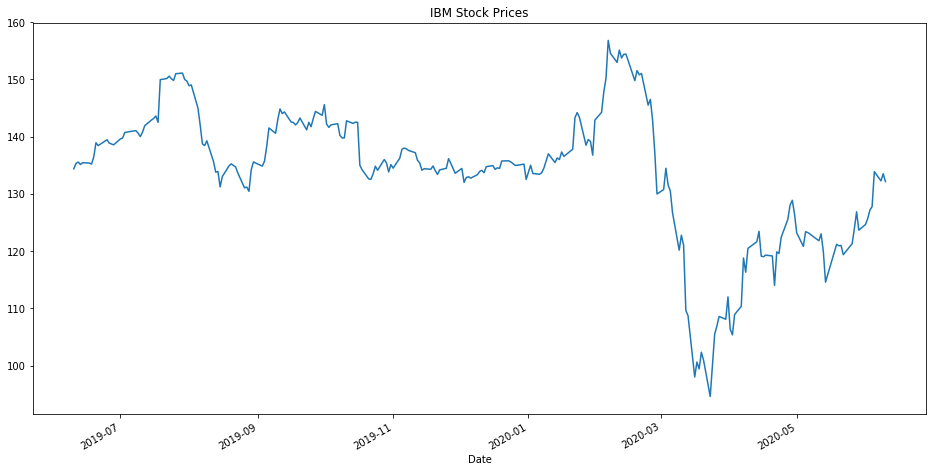

In [273]:
df['Open'].plot(label = 'IBM', figsize =(16,8), title = 'IBM Stock Prices')
plt.show()

### Plotting out the 10-days forward looking volatility of IBM Stock Prices 

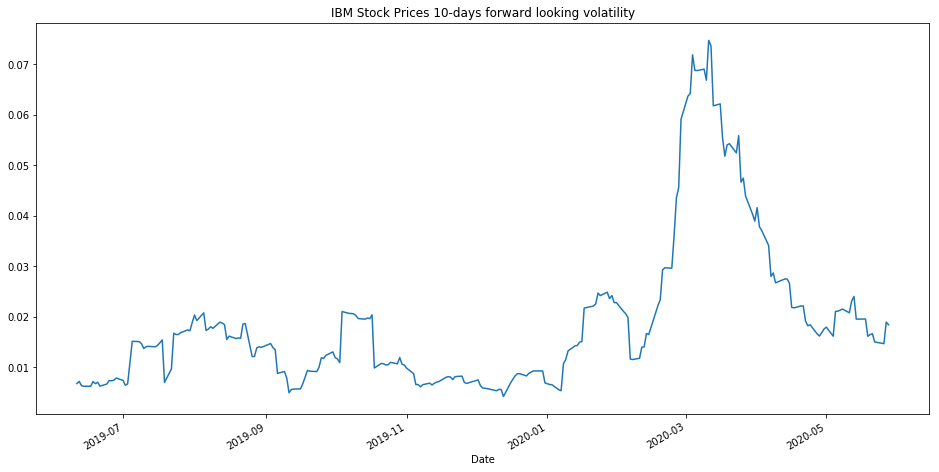

In [274]:
df['Next_10_Days_Volatility'].plot(label = 'IBM', figsize =(16,8), title = 'IBM Stock Prices 10-days forward looking volatility')
plt.show()

### Pearson Correlation Matrix

In [275]:
def build_pearson_correlation_matrix_of_dataframe(size_x,size_y,dataframe,correlation_target,correlation_minimum_criteria):

    # Using Pearson Correlation

    plt.figure(figsize=(size_x,size_y))
    cor = dataframe.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.savefig('Images/pearson_correlation_matrix.png', bbox_inches='tight')
    plt.show()

    # Correlation with output variable

    target = abs(cor[correlation_target])

    #Selecting and printing highly correlated features

    relevant_features = target[target>correlation_minimum_criteria]
    print(relevant_features)

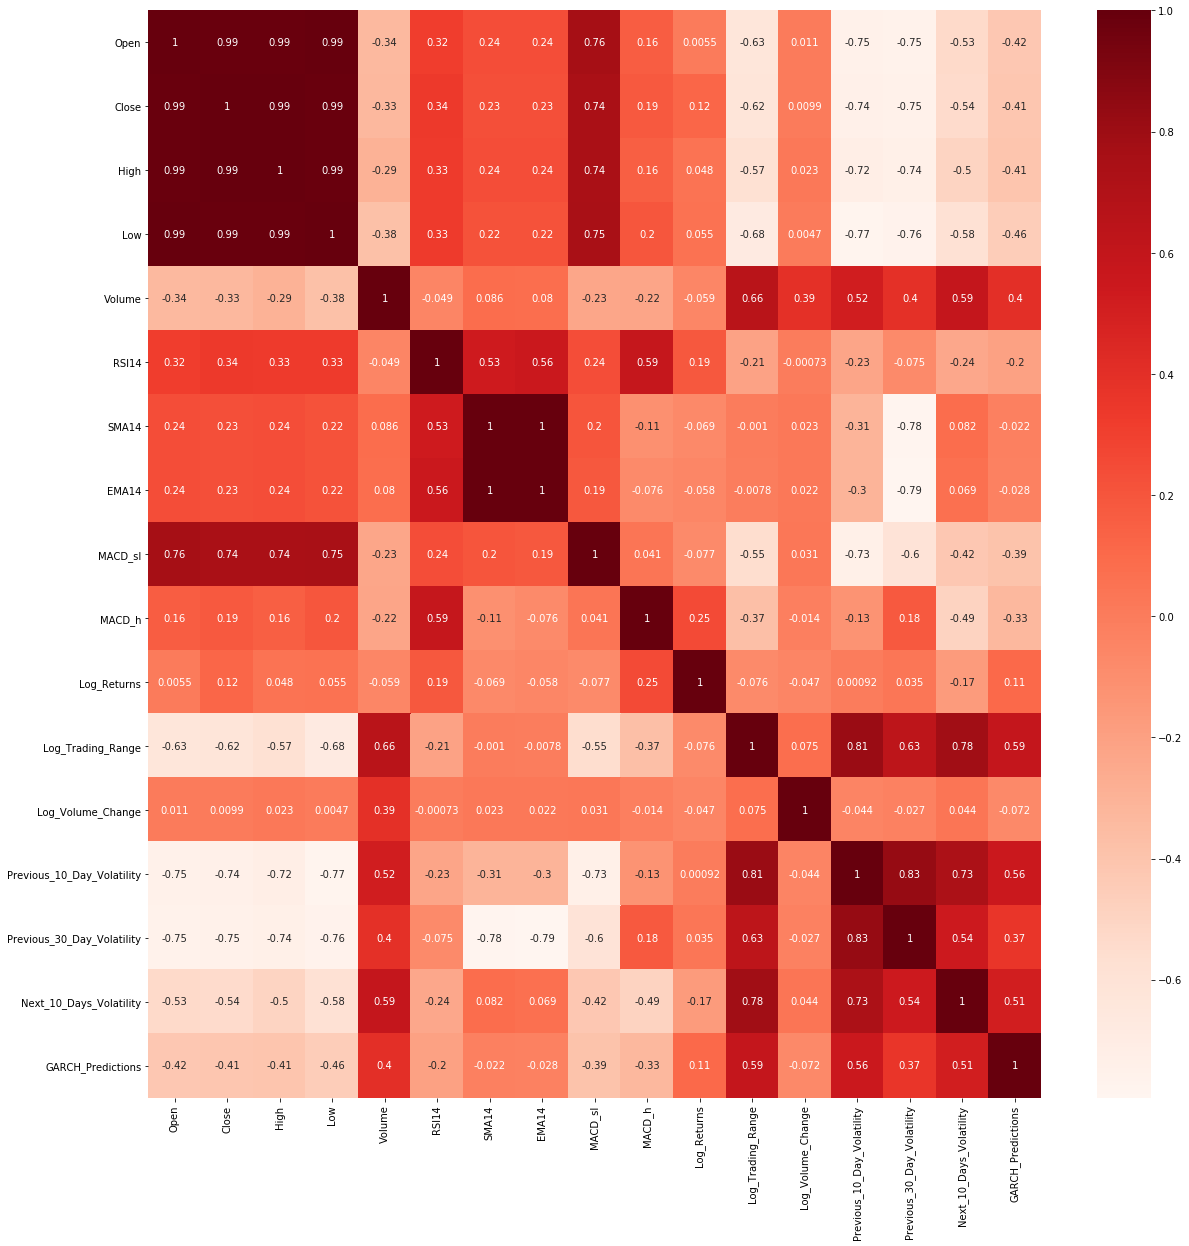

Open                          0.529545
Close                         0.538019
High                          0.498592
Low                           0.577579
Volume                        0.589667
RSI14                         0.239622
MACD_sl                       0.423028
MACD_h                        0.487282
Log_Trading_Range             0.783340
Previous_10_Day_Volatility    0.732002
Previous_30_Day_Volatility    0.539643
Next_10_Days_Volatility       1.000000
GARCH_Predictions             0.510456
Name: Next_10_Days_Volatility, dtype: float64


In [276]:
build_pearson_correlation_matrix_of_dataframe(20,20,df,"Next_10_Days_Volatility",0.2)

# Data Preparation

In [277]:
X = np.array(df.drop(["Next_10_Days_Volatility"], axis=1).values)
y = np.array(df["Next_10_Days_Volatility"].values).reshape(-1, 1) # don't have to use it, a 2 d vector with 1 column instead of a dimension vector

test_size = 100
X_train = X[test_size:,]
X_test = X[:test_size,]
y_train = y[test_size:]
y_test = y[:test_size]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(154, 16) (154, 1)
(100, 16) (100, 1)


### Defining a function to get lagged versions of the features

This function increases the number of features of the dataset by "lagging" every feature.

In [278]:
def get_lagged(x, y, t, s):
    
    lagged = []
    
    for i in range(x.shape[0] - t):
        
        if i == x.shape[0] - t:
            
            break
            
        for k in range(t):
            
            if k < t:
                
                lagged.append(x[i+k])
                
    lagged = np.array(lagged).reshape(s)
    
    return lagged, y[:lagged.shape[0],]

In [279]:
N = 30

X_train, y_train = get_lagged(X_train, y_train, N, (X_train.shape[0]-N, N*X_train.shape[1]))
X_test, y_test = get_lagged(X_test, y_test, N, (X_test.shape[0]-N, N*X_test.shape[1]))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(124, 480) (70, 480)
(124, 1) (70, 1)


In [280]:
T = 4

X_train, y_train = get_lagged(X_train, y_train, T, (X_train.shape[0]-T, T, X_train.shape[1]))
X_test, y_test = get_lagged(X_test, y_test, T, (X_test.shape[0]-T, T, X_test.shape[1]))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(120, 4, 480) (66, 4, 480)
(120, 1) (66, 1)


# LSTM

### Building the LSTM Model

In [281]:
inputLSTM = Input(shape=(X_train.shape[1], X_train.shape[2]))
y = LSTM(200, return_sequences=True)(inputLSTM)
y = LSTM(200)(y)
y = Dense(1)(y)
lstm = Model(inputs=inputLSTM, outputs=y)
lstm.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 4, 480)]          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 4, 200)            544800    
_________________________________________________________________
lstm_11 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 865,801
Trainable params: 865,801
Non-trainable params: 0
_________________________________________________________________


### Plotting out the LSTM network

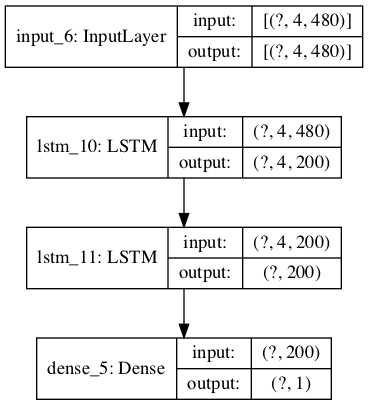

In [282]:
plot_model(lstm, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Declaring the parameters of the LSTM Model

In [283]:
lstm.compile(optimizer='adam',loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.RootMeanSquaredError()])

### Fitting the LSTM Model

In [284]:
hist = lstm.fit(X_train, y_train,batch_size=32,epochs=50,verbose=0,validation_split=0.3,shuffle=False)

### Plotting the RSME for training and validation

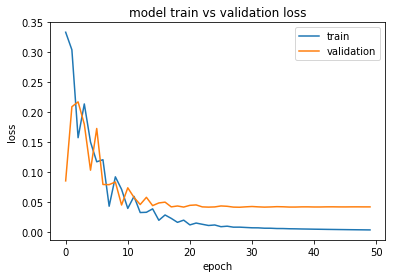

In [285]:
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Using the LSTM Model to make predictions

In [286]:
y_predictions = lstm.predict(X_test)

### Printing out the predictions made by the model

In [287]:
for ind, i in enumerate(y_predictions):
    
    print(i[0], ",", y_test[ind][0])

nan , nan
nan , 0.006712424878685967
nan , 0.007139223727128545
nan , 0.006289396196984633
nan , 0.006178358913218951
nan , 0.006176320477700085
nan , 0.007119620579225886
nan , 0.006688506160341776
nan , 0.006982496557604799
nan , 0.006194866843999701
nan , 0.006625510949417798
nan , 0.007318261427377604
nan , 0.007262353299671095
nan , 0.007365964236466215
nan , 0.007800807072327359
nan , 0.00734419800933154
nan , 0.006382329863624248
nan , 0.006640651198136994
nan , 0.015094143446023348
nan , 0.015028966282043728
nan , 0.01462899869258804
nan , 0.013673307835133592
nan , 0.014026290005299995
nan , 0.014086932696441998
nan , 0.014007574146590394
nan , 0.014295023333686699
nan , 0.014812339654022497
nan , 0.01536544746138651
nan , 0.006936635297622576
nan , 0.009626644301312614
0.05463403 , 0.016700007904535248
0.034968775 , 0.016446794445306456
0.047777962 , 0.016438016131816616
-0.01569961 , 0.01681657252461334
-0.05277616 , 0.0173456249328676
0.027501734 , 0.01718267222737783
0.064